## LDA Approximation in the 1nn case

#### Imports

In [9]:
import numpy as np
from src.utils_nambu_system import parallel_nambu_diagonalization_ising_model
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def pade(z:np.ndarray,a_p,b_p,c_p,d_p,e_p,a_q,b_q,c_q,d_q):
    z_poly=z[None,:]**(4-np.arange(5))[:,None]
    f=(z_poly[0,:]*a_p+z_poly[1,:]*b_p+z_poly[2,:]*c_p+z_poly[3,:]*d_p+z_poly[-1,:]*e_p)/(z_poly[0,:]*a_q+z_poly[1,:]*b_q+z_poly[2,:]*c_q+z_poly[3,:]*d_q)
    return f

def lda_functional(z:np.ndarray,coeff:np.ndarray):
    
    f_lda=np.zeros((z.shape[0],z.shape[-1]))
    
    #sorry for this free loop
    for i in range(z.shape[-1]):
        f_lda[:,i]=pade(z[:,i],a_p=coeff[0],b_p=coeff[1],c_p=coeff[2],d_p=coeff[3],e_p=coeff[4],a_q=coeff[5],b_q=coeff[6],c_q=coeff[7],d_q=coeff[8])
    return f_lda

#### Data

100%|██████████| 100/100 [00:02<00:00, 45.24it/s]


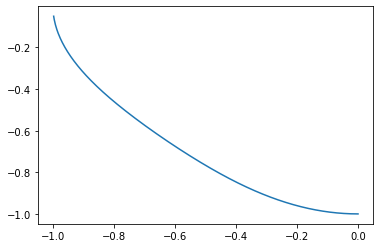

In [2]:
hmax=10
ndata=5000
l=16
nbatch=100
j_coupling=1
device='cpu'
pbc=True



hs=np.linspace(0,hmax,ndata)[:,None]*np.ones(l)[None,:]

_, ms, _, f, fm, e = parallel_nambu_diagonalization_ising_model(
        nbatch=nbatch,
        l=l,
        j_coupling=j_coupling,
        hs=hs,
        device=device,
        pbc=pbc,
    )

f=np.average(fm,axis=-1)
z=np.average(ms,axis=-1)
plt.plot(z,f)
plt.show()



#### Fit the LDA in case of costant fields

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


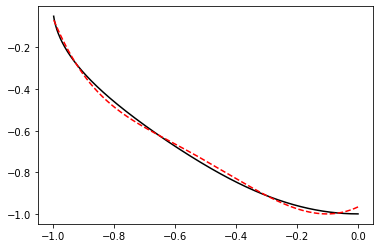

In [3]:
deg=5
coeff=np.polyfit(z,f,deg=deg)

z_poly=z[:,None]**(deg-np.arange(deg+1)[None,:])
f_lda=np.einsum('k,ak->a',coeff,z_poly)

plt.plot(z,f,color='black')
plt.plot(z,f_lda,linestyle='--',color='red')
plt.show()



def f_lda(z:np.ndarray,coeff:np.ndarray):
    
    z_poly=z[:,:,None]**(deg-np.arange(deg+1)[None,None,:])
    
    return np.einsum('k,ijk->ij',coeff,z_poly)
    
    

(9,)
(5,)
(4,)


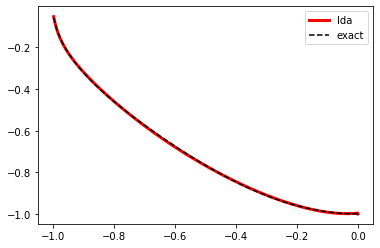

In [8]:
coeff,_=curve_fit(f=pade,xdata=z,ydata=f,)

print(coeff.shape)

coeff_p=coeff[:5]
coeff_q=coeff[5:]
print(coeff_p.shape)
print(coeff_q.shape)

f_ml=pade(z,a_p=coeff[0],b_p=coeff[1],c_p=coeff[2],d_p=coeff[3],e_p=coeff[4],a_q=coeff[5],b_q=coeff[6],c_q=coeff[7],d_q=coeff[8])



# z_poly_p=z[None,:]*(4-np.arange(5))[:,None]
# z_poly_q=z[None,:]*(3-np.arange(4))[:,None]
# f_ml=np.einsum('ka,k->a',z_poly_p,coeff_p)/np.einsum('ka,k->a',z_poly_q,coeff_q)

plt.plot(z,f_ml,color='red',label='lda',linewidth=3)
plt.plot(z,f,color='black',label='exact',linestyle='--')
plt.legend()
plt.show()

#### Test in the disorder Case

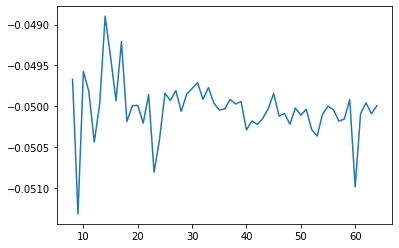

In [10]:
err=[]
ls=np.arange(8,65)
for l in ls:

    data=np.load(f'data/dataset_1nn/field2density_221122/valid_unet_periodic_{l}_l_2.7_h_200_n.npz')
    z=data['density']
    f=data['density_F']
    h=data['potential']
    
    eng=f+z*h
    f_lda=lda_functional(z,coeff=coeff)


    err.append(np.average(np.average(np.abs(f_lda-f),axis=-1)/np.average(eng,axis=-1)))

plt.plot(ls,err)
plt.show()






#### Consider the LDA in the z_ave f_ave condition